In [158]:
import numpy as np
import pandas as pd
import csv
import time
#torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.loader import DataLoader # For batching graph data
from torch_geometric.utils import to_dense_adj
import torch.nn.functional as F

#sklearn
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef

# objective functions
from models.DGDNN.Train_Eval.utils import theta_regularizer, neighbor_distance_regularizer

#Visualize and create graph/charts
import networkx as nx
import matplotlib.pyplot as plt

#Path managment
import os
import sys



from IPython.display import clear_output
torch.__version__
device = 'gpu' if torch.cuda.is_available() else 'cpu'
torch.seed = 1234

### Add the DGDNN libraries into the path to get Data

In [159]:
model_path = os.path.abspath('/Users/mirco/Documents/Tesi/code/models/DGDNN/Model')
if model_path not in sys.path:
    sys.path.insert(0, model_path)
data_path = os.path.abspath('/Users/mirco/Documents/Tesi/code/models/DGDNN/Data')
if data_path not in sys.path:
    sys.path.insert(0, data_path)
    

In [160]:
p = '/Users/mirco/Documents/Tesi/code/data/datasets/America_Stocks'
for file in os.listdir(p):
    print(os.path.getsize( os.path.join(p, file)))

225767
454640
33
30908
176858
170955
223693
33
431828
17362
28096
848
33
15378
75420
3081
157205
42823
151528
204194
207677
33
371507
33
33
33
3500
174447
140569
156275
343211
33
33
447254
196846
33
302580
6530
33
26526
33
19059
33
424578
329313
33
362847
70289
51637
172738
124774
33
33
84210
38758
453074
54144
161826
45079
33
353144
93030
33
59814
373044
152967
17184
33
198234
10817
437274
50248
422879
246592
33
123015
326
386313
33
319726
298960
386491
33
33
424553
328590
75664
45385
138562
38991
437907
67245
4462
146095
239096
64882
33
314875
196104
363143
53294
150575
282646
33
33
35713
102700
33
29897
33
437348
33
372313
77851
33
191701
66480
322278
33
256961
58653
13458
300211
401736
24226
1766
59326
170187
346567
16303
33
33
39997
2292
434250
260458
5514
2706
33
33
76489
111138
12166
176180
70170
266764
289509
146607
61163
401285
57585
78398
423745
43810
316822
33
33
398364
260
376189
157933
441241
58202
33
9366
21874
411033
75240
33
60967
85279
408265
33
156700
99822
33
33
4354

# The dataset 

In [161]:
from geometric_dataset_gen import MyDataset as MyGeometricDataset
from dataset_gen import MyDataset 

In [162]:
# # Configure the default variables // # these can be tuned // # examples
sedate = ['2013-01-01', '2014-12-31']  # these can be tuned
val_sedate = ['2015-01-01', '2015-06-30'] # these can be tuned
test_sedate = ['2015-07-01', '2017-12-31'] # these can be tuned
market = ['NASDAQ', 'NYSE', 'SSE'] # can be changed
dataset_type = ['Train', 'Validation', 'Test']

com_path = ['/Users/mirco/Documents/Tesi/code/data/datasets/NASDAQ.csv',
            '/Users/mirco/Documents/Tesi/code/data/datasets/NYSE.csv',
            '/Users/mirco/Documents/Tesi/code/data/datasets/NYSE_missing.csv'
            ] # Where the company tickers are

des = "/Users/mirco/Documents/Tesi/code/data/datasets/graph_snapshots/" # Where to save the processed graphs

# directory = "/Users/mirco/Documents/Tesi/code/data/datasets/America_Stocks" 
# window = 19
# NASDAQ_com_list = []
# NYSE_com_list = []
# NYSE_missing_list = []
# com_list = [NASDAQ_com_list, NYSE_com_list, NYSE_missing_list] #Ticker lists

# for idx, path in enumerate(com_path): #Per each ticker folder get the path and index
#     with open(path) as f:
#         file = csv.reader(f)
#         for line in file:
#             com_list[idx].append(line[0])  # append first element of line if each line is a list
# NYSE_com_list = [com for com in NYSE_com_list if com not in NYSE_missing_list] #Filter the com on NYSE since they are missing 
# fast_approx = False # True for fast approximation and implementation
# # Generate datasets

# # Market: 0:Nasdaq 1:NYSE 2:SSE
# # root: str, desti: str, market: str, comlist: List[str], start: str, end: str, window: int, dataset_type: str, fast_approx
# print("-"*5, "Building train dataset..." , "-"*5)
# #Market: 0:Nasdaq 1:NYSE 2:SSE
#  #                      root: str, desti: str, market: str, comlist: List[str], start: str, end: str, window: int, dataset_type: str, fast_approx
# train_dataset = MyGeometricDataset(directory, des, market[0], NASDAQ_com_list, sedate[0], sedate[1], window, dataset_type[0], fast_approx) 
# print("-"*5, "Building validation dataset..." , "-"*5)
# validation_dataset = MyGeometricDataset(directory, des, market[0], NASDAQ_com_list, val_sedate[0], val_sedate[1], window, dataset_type[1], fast_approx)
# print("-"*5, "Building test dataset..." , "-"*5)
# test_dataset = MyGeometricDataset(directory, des, market[0], NASDAQ_com_list, test_sedate[0], test_sedate[1], window, dataset_type[2], fast_approx)

In [163]:
# To reload modulse if needed
%reload_ext autoreload
%autoreload 2

In [164]:
dir = 'data/datasets/America_Stocks'
dest = 'data/datasets/graph/'
market = 'NASDAQ'
company_list = ['AAPL', 'ACWI',
'ADSK',
'ADTN',
'ADUS',
'AEGN']

train_sedate = ['2012-05-01', '2014-12-31']  # these can be tuned
val_sedate = ['2015-01-01', '2015-06-30'] # these can be tuned
test_sedate = ['2015-07-01', '2016-06-30'] # these can be tuned
dataset_type = ['Train', 'Validation', 'Test']
window_size = 2  # 
dataset_label = 'train'
use_fast_approximation = False

print("-"*5, "Building train dataset..." , "-"*5)
train_dataset = MyGeometricDataset(dir, dest, market, company_list, train_sedate[0], train_sedate[1], window_size, dataset_type[0], use_fast_approximation) 
print("-"*5, "Building validation dataset..." , "-"*5)
validation_dataset = MyGeometricDataset(dir, dest, market, company_list, val_sedate[0], val_sedate[1], window_size, dataset_type[1], use_fast_approximation)
print("-"*5, "Building test dataset..." , "-"*5)
test_dataset = MyGeometricDataset(dir, dest, market, company_list, test_sedate[0], test_sedate[1], window_size, dataset_type[2], use_fast_approximation)
clear_output()


In [165]:
print(f"Number of snapshots graph of the dataset: {len(train_dataset)}")
print(f"Graph snapshot structure: {train_dataset[0]}")
print(f"Number of nodes: {len(train_dataset[0].x)}")
print(f"Number of target labels: {len(train_dataset[0].y)}")

Number of snapshots graph of the dataset: 671
Graph snapshot structure: Data(x=[6, 10], edge_index=[2, 36], edge_attr=[36], y=[6])
Number of nodes: 6
Number of target labels: 6



Visualizing Graph...
Number of nodes: 6
Number of edges: 21
tensor([0, 0, 1, 0, 1, 1])


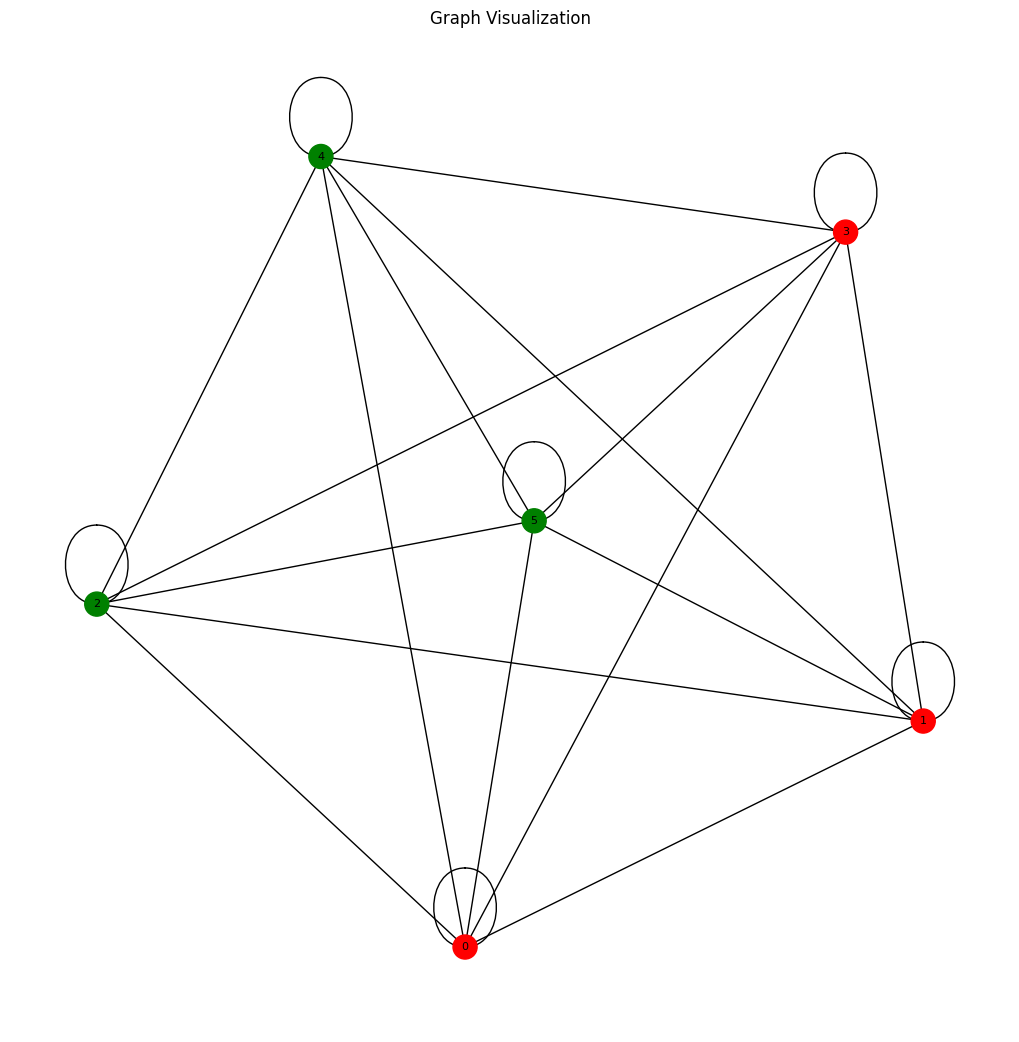

In [166]:
def visualize_geometric_graph(data_sample):
    """
    Visualizes a single torch_geometric.data.Data graph sample.
    """
    # Create a NetworkX graph object
    G = nx.Graph()

    # The edge_index tensor is of shape [2, num_edges].
    # We need to transpose it and convert to a list of tuples.
    edge_list = data_sample.edge_index.t().tolist()

    # Add edges to the graph. Nodes are added automatically.
    G.add_edges_from(edge_list)

    print(f"\nVisualizing Graph...")
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")

    # Use the labels (Y tensor) to color the nodes
    # For example, class 0 is blue, class 1 is red
    colors = ['red' if label == 0 else 'green' for label in data_sample.y] 
    print(data_sample.y)
    # Draw the graph
    plt.figure(figsize=(10, 10))
    nx.draw(G, with_labels=True, node_color=colors, node_size=300, font_size=8)
    plt.title("Graph Visualization")
    plt.show()

# Visualize the first graph in the dataset

visualize_geometric_graph(test_dataset[0])

# Model 1: GConvGRU

In [167]:
from torch_geometric_temporal.nn import GConvGRU

# Model 2: DGDNN

GitHub: https://github.com/pixelhero98/DGDNN

In [168]:

from dgdnn import DGDNN 

## Define the model

In [169]:
####  Define model
layers = 6
num_nodes = 6 
expansion_step = 7
num_heads = 2
active_layers = [True, False, False, False, False, False]
timestamp = 2  #window
classes = 1
diffusion_size = [5*timestamp, 31*timestamp, 28*timestamp, 24*timestamp, 20*timestamp, 16*timestamp, 12*timestamp]
emb_size = [5 + 31, 64, 28 + 64, 50,
            24 + 50, 38, 20 + 38, 24,
            16 + 24, 12, 12+12, 10]  


model = DGDNN(
    diffusion_size=diffusion_size,
    embedding_size=emb_size,
    classes=1,
    layers=layers,
    num_nodes=num_nodes,
    expansion_step=expansion_step,
    num_heads=num_heads,
    active=active_layers,
    timestamp=timestamp
)

## Train DGDNN

In [170]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [175]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss() # For binary classification (output is a single logit)
num_epochs = 10 # Example
threshold = 0.5

model.train()
for epoch in range(num_epochs):
    all_preds = []
    all_labels = []
    total_loss = 0
    for data in train_loader: # data will be a Batch object, even with batch_size=1
        data = data.to(device)
        optimizer.zero_grad()

        # Extract node features
        # For batch_size=1, data.x is [num_nodes, node_features_dim]
        X = data.x 

        # Convert edge_index and edge_attr to a dense adjacency matrix
        # For batch_size=1, to_dense_adj returns [1, num_nodes, num_nodes]
        # Squeeze it to get [num_nodes, num_nodes] as expected by the model.
        A = to_dense_adj(data.edge_index, 
                         batch=data.batch, # Important for correct batch processing if batch_size > 1
                         edge_attr=data.edge_attr, 
                         max_num_nodes=num_nodes).squeeze(0) # Squeeze for batch_size=1
        
        C = data.y.unsqueeze(dim=1).type(dtype=torch.float32)
        # Forward pass
        # DGDNN expects X: [num_nodes, features], A: [num_nodes, num_nodes]
        outputs = model(X, A) # Output shape: [num_nodes, classes]

        loss = criterion(outputs, C) - 0.0029 * neighbor_distance_regularizer(model.theta) + theta_regularizer(model.theta)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        #loss.step()
        total_loss += loss.item()
        # Accumuliamo i logits e le etichette per calcolare accuracy a fine epoca
        all_preds.append(outputs.detach().cpu().view(-1))       # [num_nodes]
        all_labels.append(C.detach().cpu().long().view(-1))     # [num_nodes]

    avg_loss = total_loss / len(train_loader)
    # Apply threshold to convert outputs to binary predictions
      # or any other value you want
    # Compute accuracy
    y_logits = torch.cat(all_preds).flatten()
    y_true = torch.cat(all_labels).flatten()

    # Convert logits to binary predictions (0 or 1)
    # A positive logit corresponds to predicting class 1.
    y_pred = (y_logits > 0).long()

    # Calculate metrics using the full dataset's predictions
    acc = accuracy_score(y_true.numpy(), y_pred.numpy())
    f1 = f1_score(y_true.numpy(), y_pred.numpy())
    mcc = matthews_corrcoef(y_true.numpy(), y_pred.numpy())
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}, acc={acc:.4f}, f1={f1:.4f}, mcc={mcc:.4f}")
     

print("Training finished.")

Epoch 1/10, Average Loss: 0.6810, acc=0.5067, f1=0.6047, mcc=-0.0064
Epoch 2/10, Average Loss: 0.6802, acc=0.5149, f1=0.6328, mcc=0.0056
Epoch 3/10, Average Loss: 0.6801, acc=0.5164, f1=0.6282, mcc=0.0111
Epoch 4/10, Average Loss: 0.6810, acc=0.5102, f1=0.6405, mcc=-0.0116
Epoch 5/10, Average Loss: 0.6795, acc=0.5164, f1=0.6223, mcc=0.0127
Epoch 6/10, Average Loss: 0.6806, acc=0.5117, f1=0.6468, mcc=-0.0104
Epoch 7/10, Average Loss: 0.6805, acc=0.5114, f1=0.6541, mcc=-0.0164
Epoch 8/10, Average Loss: 0.6810, acc=0.5070, f1=0.6423, mcc=-0.0232
Epoch 9/10, Average Loss: 0.6797, acc=0.5224, f1=0.6643, mcc=0.0181
Epoch 10/10, Average Loss: 0.6803, acc=0.5079, f1=0.6169, mcc=-0.0075
Training finished.


## Test the model

In [176]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [177]:
# Use torch.no_grad() for evaluation to improve speed and save memory
model.eval()
criterion = nn.BCEWithLogitsLoss()

all_logits = []
all_labels = []
total_test_loss = 0

with torch.no_grad():  # Deactivates autograd for efficiency
    for data in test_loader:
        data = data.to(device)
        
        # --- Data Preparation ---
        X = data.x
        A = to_dense_adj(data.edge_index,
                         batch=data.batch,
                         edge_attr=data.edge_attr,
                         max_num_nodes=num_nodes).squeeze(0)
        
        # Use data.y for labels and prepare for loss calculation
        C = data.y.unsqueeze(dim=1).float() 
        
        # --- Forward pass and Loss Calculation ---
        outputs = model(X, A)
        loss = criterion(outputs, C)  # Note: Regularizers are often omitted during evaluation
        total_test_loss += loss.item()
        
        # --- Accumulate logits and labels ---
        # Store the raw model outputs (logits) and the true labels
        all_logits.append(outputs.cpu())
        all_labels.append(data.y.cpu()) # Store the original 0/1 labels

# --- Post-loop calculations ---
# Concatenate all stored tensors from all batches
y_logits = torch.cat(all_logits).flatten()
y_true = torch.cat(all_labels).flatten()

# Convert logits to binary predictions (0 or 1)
# A positive logit corresponds to predicting class 1.
y_pred = (y_logits > 0).long()

# Calculate metrics using the full dataset's predictions
acc = accuracy_score(y_true.numpy(), y_pred.numpy())
f1 = f1_score(y_true.numpy(), y_pred.numpy())
mcc = matthews_corrcoef(y_true.numpy(), y_pred.numpy())

# Calculate and print average loss and metrics
avg_test_loss = total_test_loss / len(test_loader)

print(f"Test Results:")
print(f"Average Loss: {avg_test_loss:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")

Test Results:
Average Loss: 0.6939
Accuracy: 0.4954
F1 Score: 0.3901
MCC: -0.0140


## Temp maybe usefull

In [ ]:
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal #Handle dynamic temporal graph